In [1]:
import sys
sys.path.append("../../src")
import os
import datetime
import pandas as pd
import numpy as np
import numpy as np
from sindy_utils import library_size
from training import train_network
from error_utils import *
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()

from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle 
import copy
import subprocess as sp
import matplotlib.patches as patches
import seaborn as sns
from copy import deepcopy
from matplotlib.ticker import FormatStrFormatter

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 10934
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 16149


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='2'))

# Load data

In [4]:
# load training data
p1_train = np.linspace(4, 4.3, 2)
p2_train = np.linspace(1, 1.4, 2)
x0 = 0.5 # center coordinate of initial condition
num_train = p1_train.size * p2_train.size  # number of training cases
tstop = 0.3
dt = 5e-3
scaled = False # if data is normalized

if num_train > 1:
    train_data = pickle.load(open(f"./data/local{num_train}_tstop{tstop:.1f}c.p", "rb"))
else:
    train_data = pickle.load(open(f"./data/local{num_train}_p1{p1_train[0]:.1f}_p2{p2_train[0]:.1f}_tstop{tstop:.1f}.p", "rb"))
num_sindy = len(train_data['data'])
input_dim = train_data['data'][0]['x'].shape[1]

# testing data
# p1_test = p1_train
# p2_test = p2_train
p1_test = np.linspace(4, 4.3, 21)
p2_test = np.linspace(1, 1.4, 21)
num_test = p1_test.size * p2_test.size
if num_train > 1:
    test_data = pickle.load(open(f"./data/local{num_test}_tstop{tstop:.1f}c.p", "rb"))
else:
    test_data = pickle.load(open(f"./data/local{num_test}_p1{p1_test[0]:.1f}_p2{p2_test[0]:.1f}_tstop{tstop:.1f}.p", "rb"))

for i in range(num_sindy):
    print(f"case {i}: params: {train_data['param'][i]}, x shape: {train_data['data'][i]['x'].shape}")

case 0: params: [4.44 1.  ], x shape: (61, 1089)
case 1: params: [4.44 2.  ], x shape: (61, 1089)
case 2: params: [8.88 1.  ], x shape: (61, 1089)
case 3: params: [8.88 2.  ], x shape: (61, 1089)


In [5]:
grid1, grid2 = np.meshgrid(p1_train, p2_train)
train_param = np.hstack((grid1.flatten().reshape(-1,1), grid2.flatten().reshape(-1,1)))
grid1, grid2 = np.meshgrid(p1_test, p2_test)
test_param = np.hstack((grid1.flatten().reshape(-1,1), grid2.flatten().reshape(-1,1)))

train_idx = []
for i in range(num_test):
    for j in range(num_train):
        if np.abs(test_param[i,0]-train_param[j,0]) < 1e-8 and \
        np.abs(test_param[i,1]-train_param[j,1]) < 1e-8:
            train_idx.append(i)
print(train_idx)

[0, 1, 2, 3]


In [7]:
train_data_x = []
train_data_dx = []
for i in range(num_train):
    train_data_x.append(train_data['data'][i]['x'])
    train_data_dx.append(train_data['data'][i]['dx'])
train_data_x = np.vstack(train_data_x)
train_data_dx = np.vstack(train_data_dx)
print(train_data_x.shape, train_data_dx.shape)

(244, 1089) (244, 1089)


In [8]:
if scaled:
    x_min = train_data_x.min()
    train_data_x -= x_min
    x_max = train_data_x.max()
    train_data_x /= x_max

    dx_min = train_data_dx.min()
    train_data_dx -= dx_min
    dx_max = train_data_dx.max()
    train_data_dx /= dx_max
    
    for i in range(num_train):
        train_data['data'][i]['x'] = (train_data['data'][i]['x'] - x_min) / x_max
        train_data['data'][i]['dx'] = (train_data['data'][i]['dx'] - dx_min) / dx_max
    
    for i in range(num_test):
        test_data['data'][i]['x'] = (test_data['data'][i]['x'] - x_min) / x_max
        test_data['data'][i]['dx'] = (test_data['data'][i]['dx'] - dx_min) / dx_max
        
else:
    x_min = 0
    x_max = 1
    dx_min = 0
    dx_max = 1

# Set up model and training parameters

In [9]:
params = {}

params['seed'] = 1 # random seed
params['config'] = config
params['num_sindy'] = num_sindy
params['param'] = train_data['param']
params['train_idx'] = train_idx
params['input_dim'] = input_dim
params['latent_dim'] = 3
params['model_order'] = 1
params['poly_order'] = 1
params['include_sine'] = False
params['include_cosine'] = False
params['include_costant'] = True
params['library_dim'] = library_size(params['latent_dim'], params['poly_order'], 
                                     params['include_sine'], params['include_cosine'], 
                                     params['include_costant'])

# sequential thresholding parameters
params['sequential_thresholding'] = False
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
params['coefficient_initialization'] = 'constant'

# loss function weighting
params['loss_weight_decoder'] = 1.0
params['loss_weight_sindy_x'] = 1e-4
params['loss_weight_sindy_z'] = 1e-4
params['loss_weight_sindy_regularization'] = 0
params['diff'] = 'symb' # 'symb': symbolic diff (only for fully connected Autoencoder), 'auto': automatic diff
params['activation'] = 'sigmoid'
params['widths'] = [100]

# training parameters
params['epoch_size'] = train_data['data'][0]['x'].shape[0]
params['batch_size'] = train_data['data'][0]['x'].shape[0]
params['learning_rate'] = 5e-4

params['fig_path'] = os.getcwd() + '/fig/IC3c_nCase441_tstop0.3_ld3_p1_1e-4_lr5e-4_width100_nDI25_upEP1e5_resNS0.1/'
params['print_progress'] = True
params['print_frequency'] = 100
params['save_frequency'] = 100

# training time cutoffs
params['max_epochs'] = 3000000  # max number of training epochs
params['refinement_epochs'] = 0

# Greedy algorithm
params['update_epoch'] = 100000 # update training set for every 2000 epochs
params['tol'] = 0.001         # max error allowed in the parameter space
params['tol2'] = 2            # max relative error allowed in the parameter space
params['sindy_max'] = 25      # max number of local SINDys; if tolerance is used as a termination criterior, set it as None
params['convex_knn'] = 1      # the number nearest local SINDys used for convex interpolation during Greedy sampling
params['test_data'] = test_data # path of test data
params['test_param'] = np.hstack((p1_test.reshape(-1,1), p2_test.reshape(-1,1)))    # parameters of test data
params['num_test'] = num_test                     # number of test cases
params['coeff_exist'] = False                     # flag to indicate whether to initialize model coefficients with pescribed values
params['retrain'] = False     # whether to retrain the model

# Error indicator:
# 1: max relative error (if test data is available) 
# 2: residual norm (mean), 1D Burger's eqn
# 3: residual norm (mean), 2D Burger's eqn
# 4: MFEM example 16: Time dependent heat conduction
# 5: MFEM example 9: DG advection
params['err_type'] = 4                            
params['subsize'] = int(0.3 * num_test)           # initial number of random testing cases for Greedy search
params['subsize_max'] = 50                        # max percentage of random testing cases for Greedy search

# Adaptive approach for tol of error indicator:
# 'mean': use mean ratios between error indicator and max relative errors
# 'reg_mean': use linear regression line
# 'reg_max': use linear regression line shifted by std to upper bound
# 'reg_min': use linear regression line shifted by std to lower bound, more conservative
params['adaptive'] = 'reg_max'                      

# PDE parameters
params['pde'] = {}
params['pde']['exe_file'] = '../../src/ex16'
params['pde']['m_file'] = '../../src/ref-square.mesh'
params['pde']['u_file'] = './temp/ex16-u_pred1.gf'
params['pde']['res_file'] = "./temp/ex16-residual1.gf"
params['pde']['rl'] = 5
params['pde']['order'] = 1
params['pde']['ODEsolver'] = 1 # 1 - Backward Euler, 2 - SDIRK2, 3 - SDIRK3
params['pde']['tstop'] = tstop
params['pde']['dt'] = dt
params['pde']['height'] = p2_train[0]
params['pde']['width'] = p1_train[0]
# params['pde']['x1'] = p2_train[0]
# params['pde']['x2'] = p2_train[0]
params['pde']['x1'] = x0
params['pde']['x2'] = x0
params['pde']['res_ns'] = 0.1 # percentage of time steps for residual evaluation
params['pde']['Tmax_iter'] = 30 # max number of CG iterations in Tsolver


params['scaled'] = scaled # if data is normalized
params['x_min'] = x_min
params['x_max'] = x_max
params['dx_min'] = dx_min
params['dx_max'] = dx_max

In [10]:
if params['retrain']:
    save_name = 'burger_2022_03_08_08_37_10'
    params = pickle.load(open(params['fig_path'] + save_name + '_params.pkl', 'rb'))
    params['retrain'] = True
    params['coeff_exist'] = True  # flag to indicate whether to initialize model coefficients with pescribed values
    params['save_name'] = save_name
    params['max_epochs'] = 3000000
    params['update_epoch'] = 100000  # update training set for every 2000 epochs
    params['save_frequency'] = 5000
    
    for i in params['train_idx'][4:]:
        train_data['data'].append(test_data['data'][i])
        train_data['param'].append(test_data['param'][i])

# Run training experiments

In [11]:
num_experiments = 1
df = pd.DataFrame()
timer = []
timer.append(time())
for i in range(num_experiments):
    print('EXPERIMENT %d' % i)
    
    if not params['retrain']:
        params['save_name'] = 'burger_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    tf.reset_default_graph()
    results_dict = train_network(train_data, params)
    df = df.append({**results_dict, **params}, ignore_index=True)
    
timer.append(time())
print(f'training time: {(timer[-1]-timer[0])/60:.2f} mins')

EXPERIMENT 0
* Evaluating
  Time: 0.00 s, Case: [4.44 1.  ], Tol: 0.00100, Max Error: -1.000000
Epoch 0
  train loss: 1.0182e+01, decoder: 1.0154e+01, sindy-x: 2.4880e+02, sindy-z: 2.6846e+01, sindy-reg: 4.0000
Epoch 100
  train loss: 1.5840e+00, decoder: 1.5507e+00, sindy-x: 2.4861e+02, sindy-z: 8.3866e+01, sindy-reg: 3.9382
Epoch 200
  train loss: 1.1455e+00, decoder: 1.1119e+00, sindy-x: 2.4737e+02, sindy-z: 8.9146e+01, sindy-reg: 3.9079
Epoch 300
  train loss: 7.1929e-01, decoder: 6.8159e-01, sindy-x: 2.4441e+02, sindy-z: 1.3255e+02, sindy-reg: 3.8599
Epoch 400
  train loss: 4.5472e-01, decoder: 4.0980e-01, sindy-x: 2.4204e+02, sindy-z: 2.0711e+02, sindy-reg: 3.7706
Epoch 500
  train loss: 3.1614e-01, decoder: 2.7179e-01, sindy-x: 2.4123e+02, sindy-z: 2.0229e+02, sindy-reg: 3.6750
Epoch 600
  train loss: 2.4752e-01, decoder: 2.0832e-01, sindy-x: 2.3977e+02, sindy-z: 1.5218e+02, sindy-reg: 3.6187
Epoch 700
  train loss: 2.1399e-01, decoder: 1.7786e-01, sindy-x: 2.3809e+02, sindy-z: 

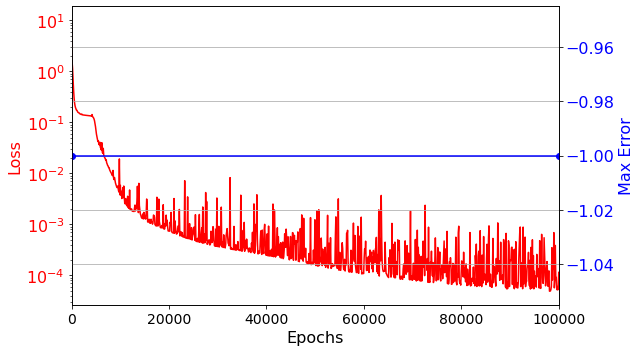

In [12]:
# history of validation loss
train_loss = np.array(df['training_losses'][0]).squeeze()
test_loss = np.array(df['testing_losses'][0]).squeeze()

fig, ax1 = plt.subplots(figsize=(9,5))
xt = np.linspace(1,df['num_epochs'][0],train_loss.shape[0])
ax1.plot(xt, train_loss[:,0], 'r', label='Train')
ax1.set_yscale('log')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', color='r', fontsize=16)
ax1.set_xlim(0, df['num_epochs'][0])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
xt = np.linspace(1,df['num_epochs'],test_loss.shape[0])
ax2.plot(xt, test_loss, 'b-o', label='Val')
ax2.set_ylabel('Max Error', color='b', fontsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='y', labelcolor='b')

plt.grid()
plt.tight_layout()
plt.savefig(f"{params['fig_path']}/loss.png")